In [11]:
import os
import glob
import subprocess
import shutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

In [3]:

def run_gort(input_dir, output_dir, process_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Find all .in files recursively in the input directory
    fplot = [os.path.join(root, file)
             for root, _, files in os.walk(input_dir)
             for file in files if file.endswith('.in')]

    # Get the current working directory at the start of the script
    initial_dir = os.getcwd()

    # Process each .in file
    for infile in fplot:
        # Get the relative path of the infile with respect to the input directory
        rel_path = os.path.relpath(infile, input_dir)
        
        # Determine the corresponding output file path
        out_file = os.path.join(output_dir, rel_path).replace('.in', '.out')
        
        # Ensure the directory for the output file exists
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
        
        # Copy the input file to gort.in in the process directory
        process_infile = os.path.join(process_dir, 'gort.in')
        shutil.copy(infile, process_infile)
        print(f"Copied {infile} to {process_infile}")
        
        # Change to the process directory
        os.chdir(process_dir)
        
        # Run the Fortran script in the process directory
        cmd_run = './gort_lidar > temp.txt'
        result = subprocess.run(cmd_run, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error running GORT model: {result.stderr}")
            break
        
        # Move gort.out from the process directory to the corresponding output file path
        process_outfile = os.path.join(process_dir, 'gort.out')
        shutil.move(process_outfile, out_file)
        print(f'Moved {process_outfile} to {out_file}')
        
        # Change back to the initial directory
        os.chdir(initial_dir)
        
# Example usage:
input_directory = '/data/shared/src/STV/LidarSimulation/OrigGORTInput/'  # Replace with your input directory path
output_directory = '/data/shared/src/STV/LidarSimulation/OrigGORTOutput/'  # Replace with your output directory path
process_directory = '/data/shared/src/STV/LidarSimulation/model/'  # Replace with your process directory path

run_gort(input_directory, output_directory, process_directory)

Copied /data/shared/src/STV/LidarSimulation/OrigGORTInput/2024_06_19/guiana/Circle_1_1_.in to /data/shared/src/STV/LidarSimulation/model/gort.in
Moved /data/shared/src/STV/LidarSimulation/model/gort.out to /data/shared/src/STV/LidarSimulation/OrigGORTOutput/2024_06_19/guiana/Circle_1_1_.out
Copied /data/shared/src/STV/LidarSimulation/OrigGORTInput/2024_06_19/guiana/Circle_1_2_.in to /data/shared/src/STV/LidarSimulation/model/gort.in
Moved /data/shared/src/STV/LidarSimulation/model/gort.out to /data/shared/src/STV/LidarSimulation/OrigGORTOutput/2024_06_19/guiana/Circle_1_2_.out
Copied /data/shared/src/STV/LidarSimulation/OrigGORTInput/2024_06_19/guiana/Circle_1_3_.in to /data/shared/src/STV/LidarSimulation/model/gort.in
Moved /data/shared/src/STV/LidarSimulation/model/gort.out to /data/shared/src/STV/LidarSimulation/OrigGORTOutput/2024_06_19/guiana/Circle_1_3_.out
Copied /data/shared/src/STV/LidarSimulation/OrigGORTInput/2024_06_19/guiana/Circle_2_1_.in to /data/shared/src/STV/LidarSimu

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/guiana_orig.pdf


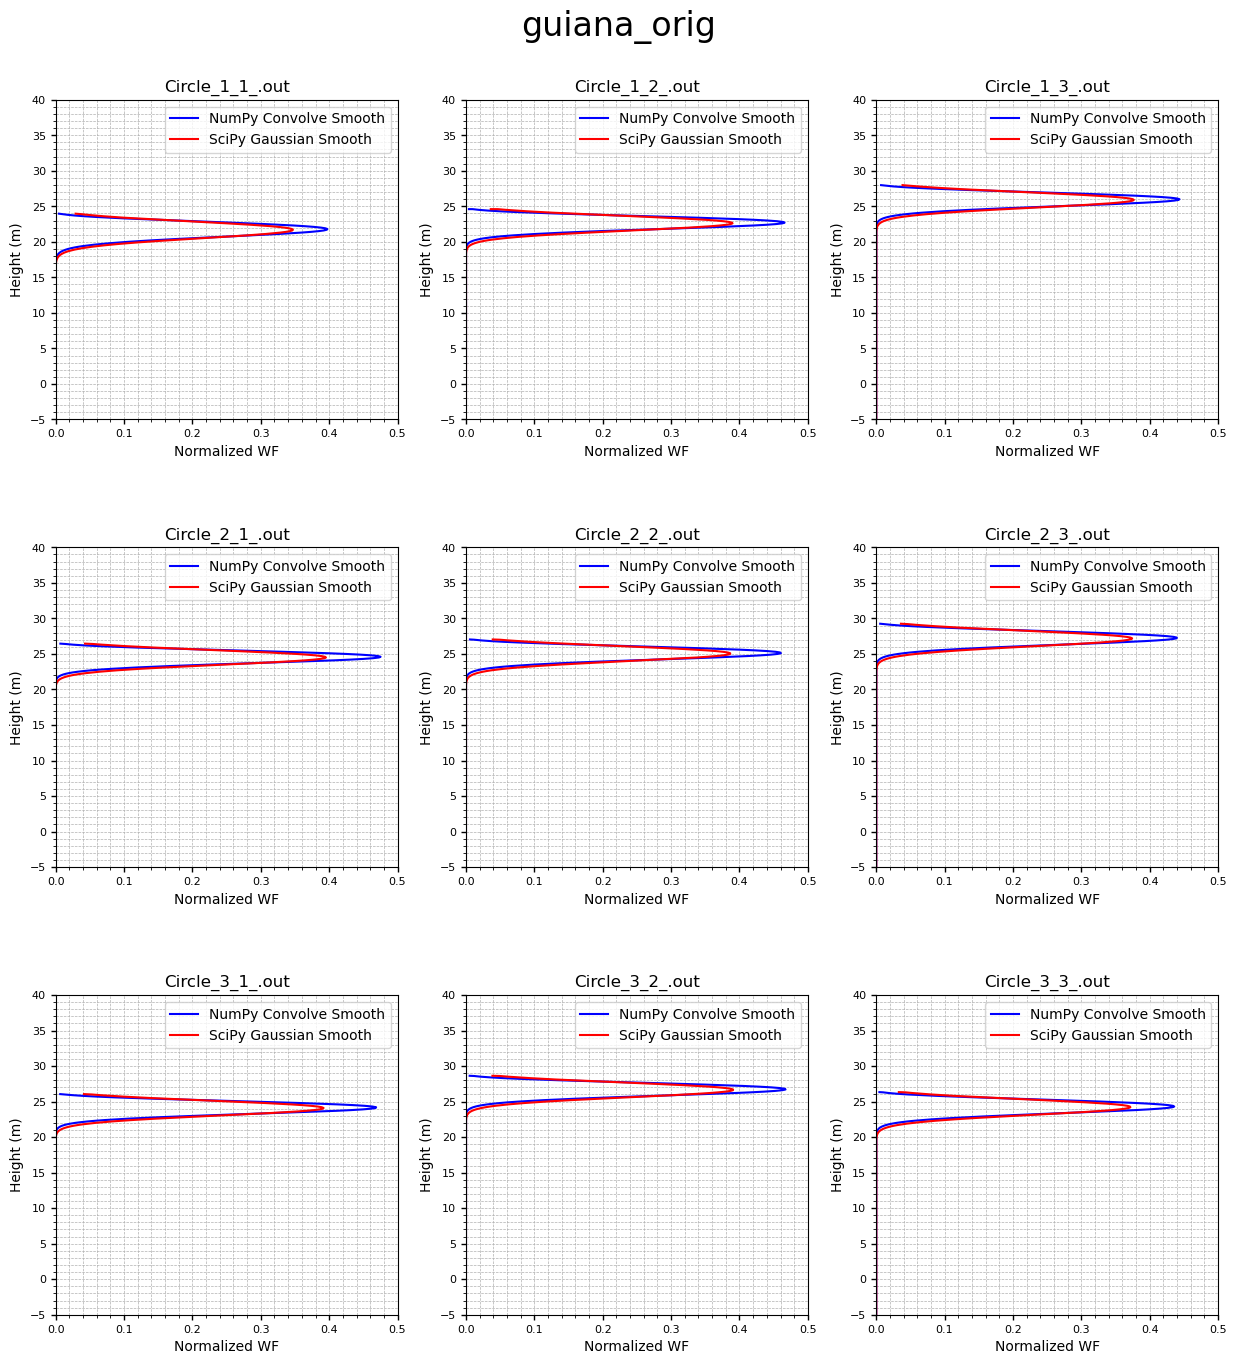

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/guiana_orig_with_branch.pdf


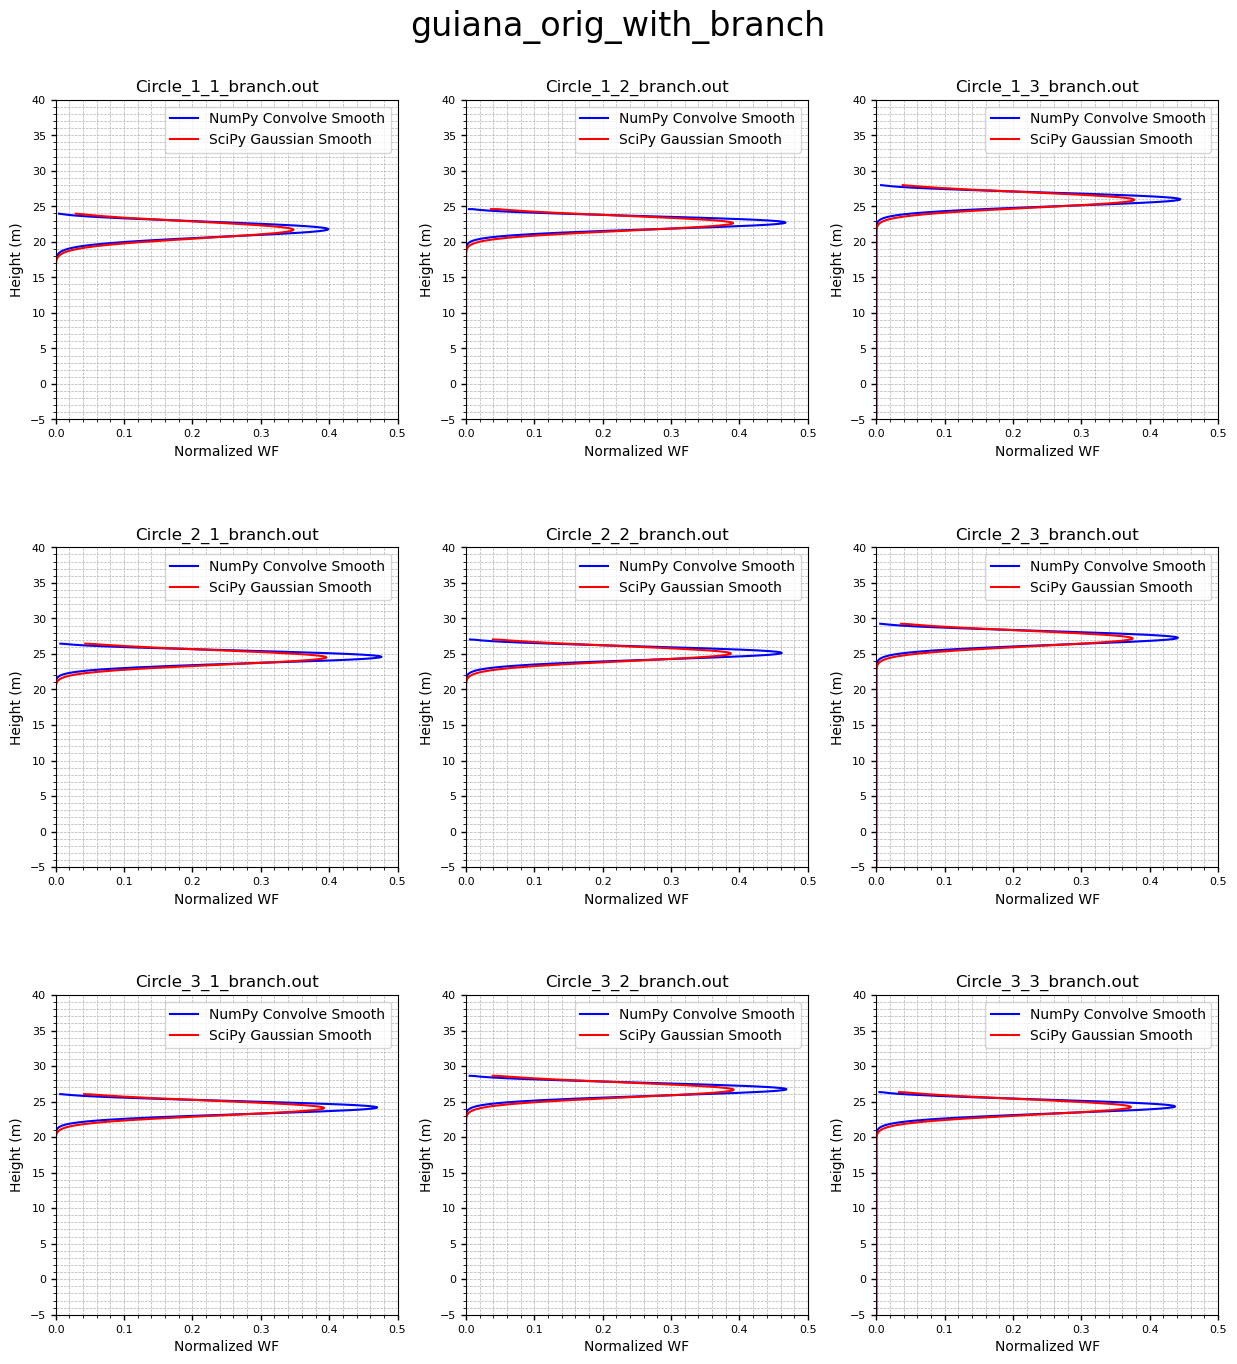

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/guiana_origLD10th.pdf


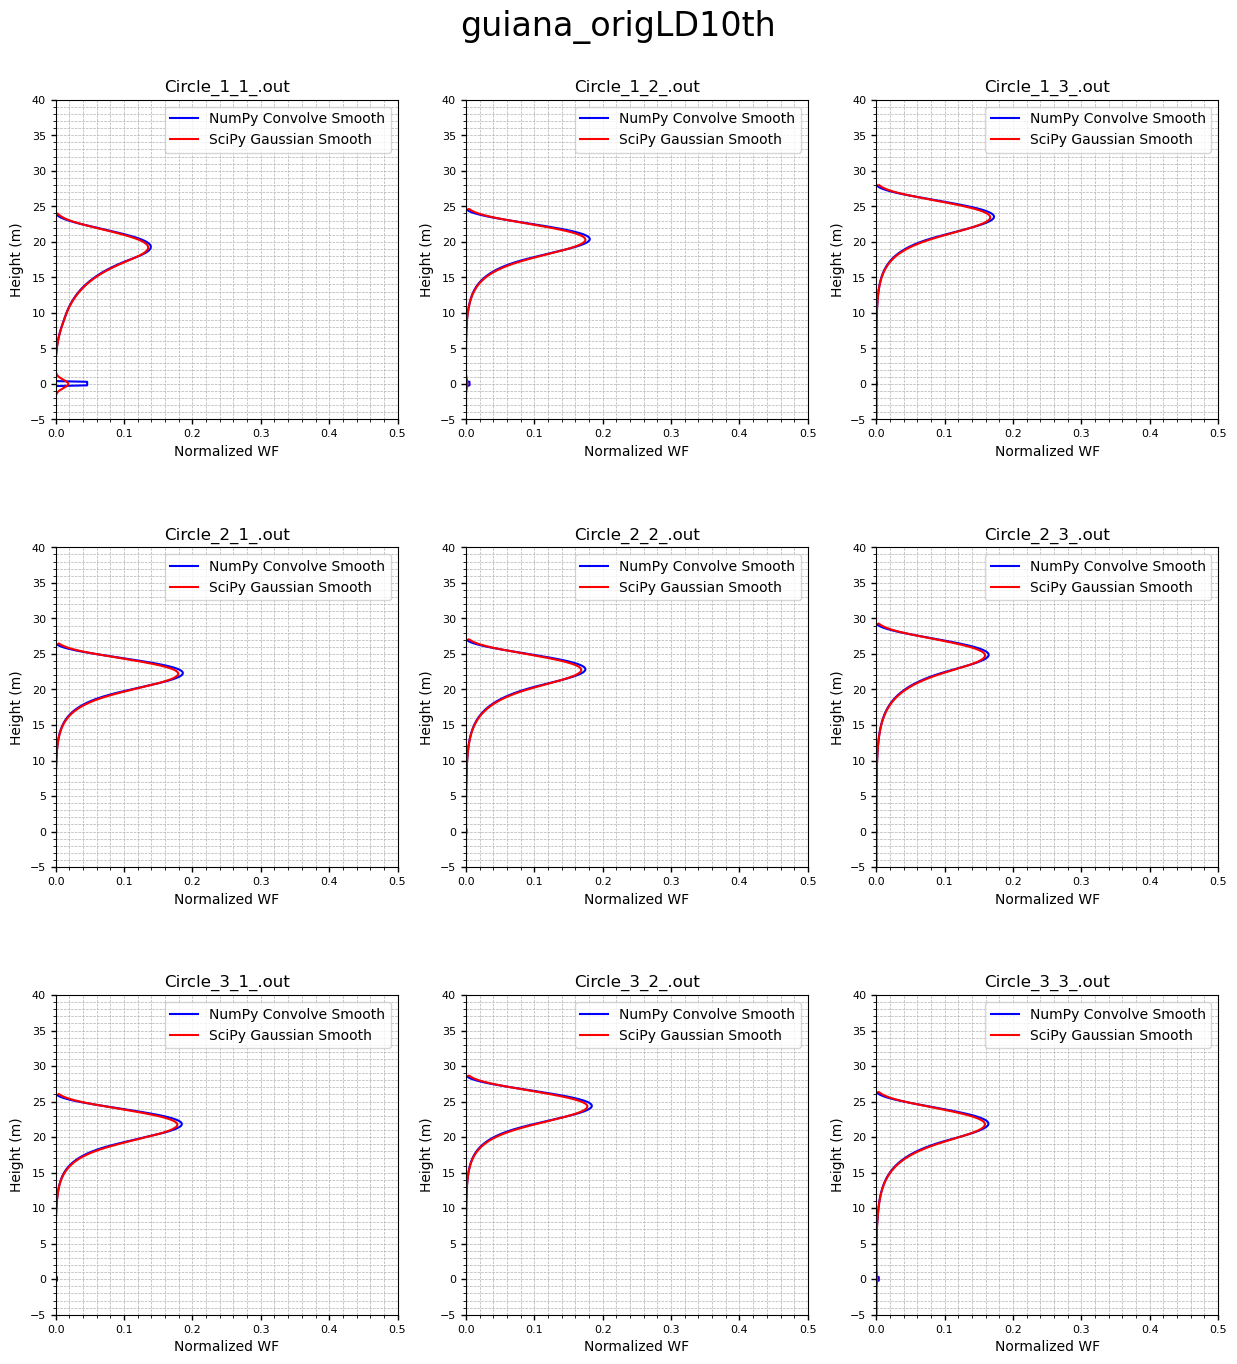

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/guiana_origLD10th_with_branch.pdf


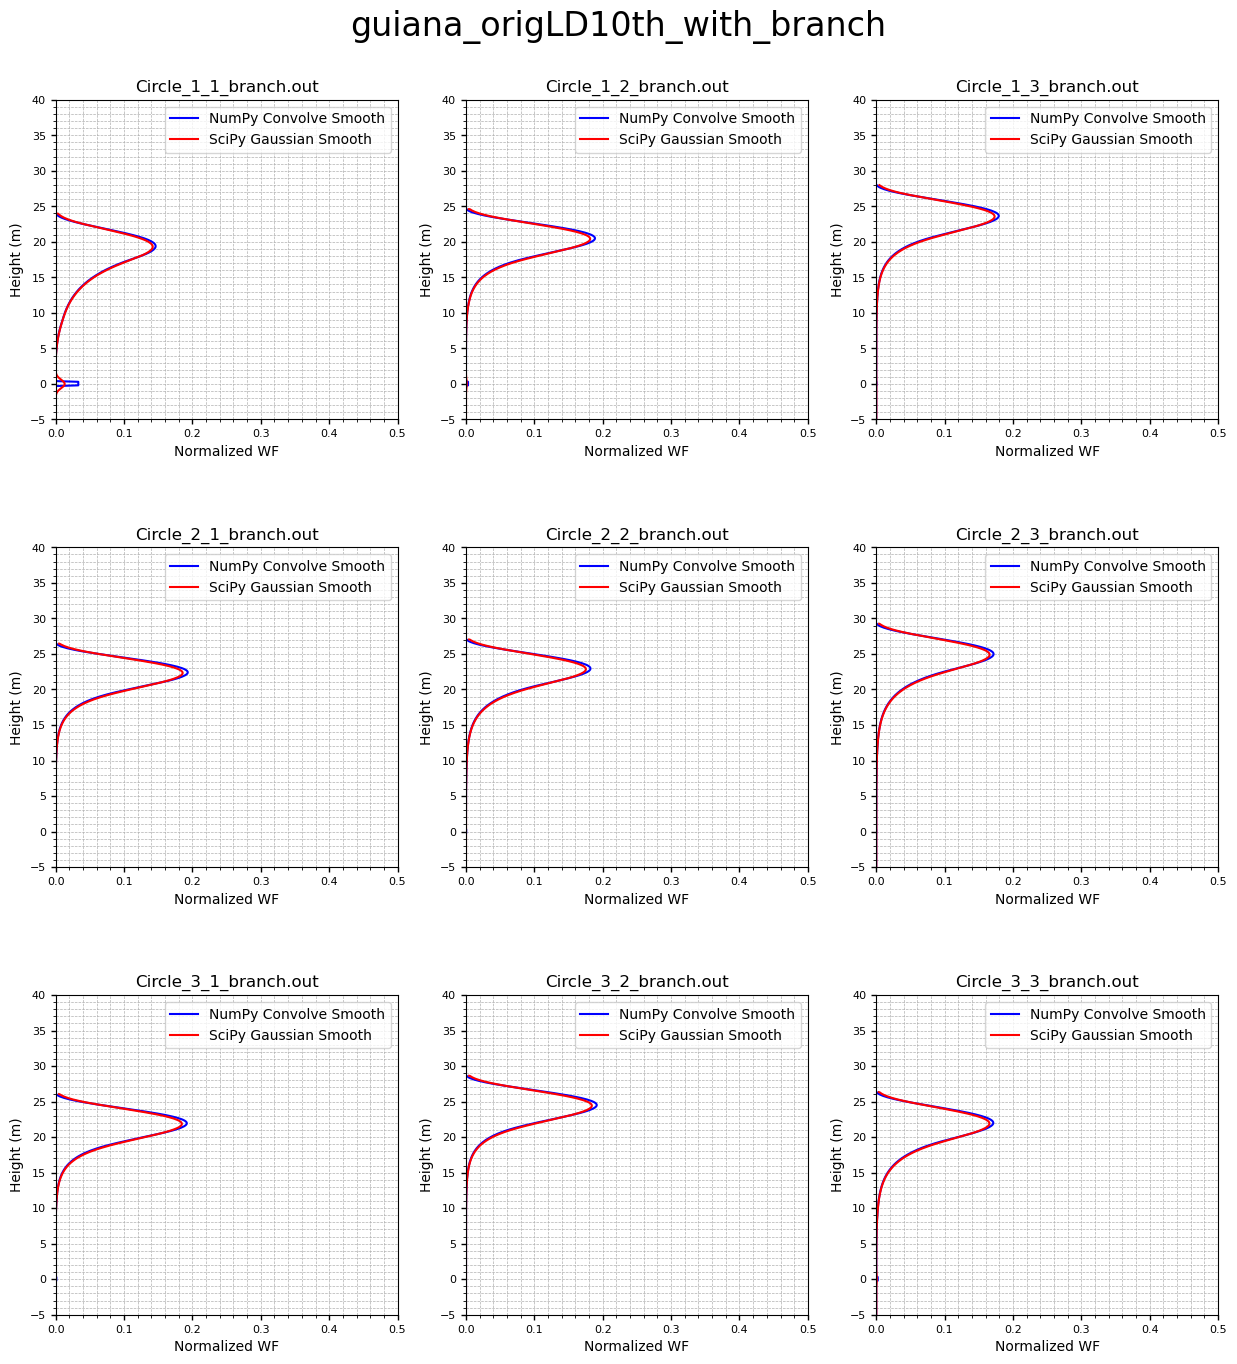

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/guiana_origLD30th.pdf


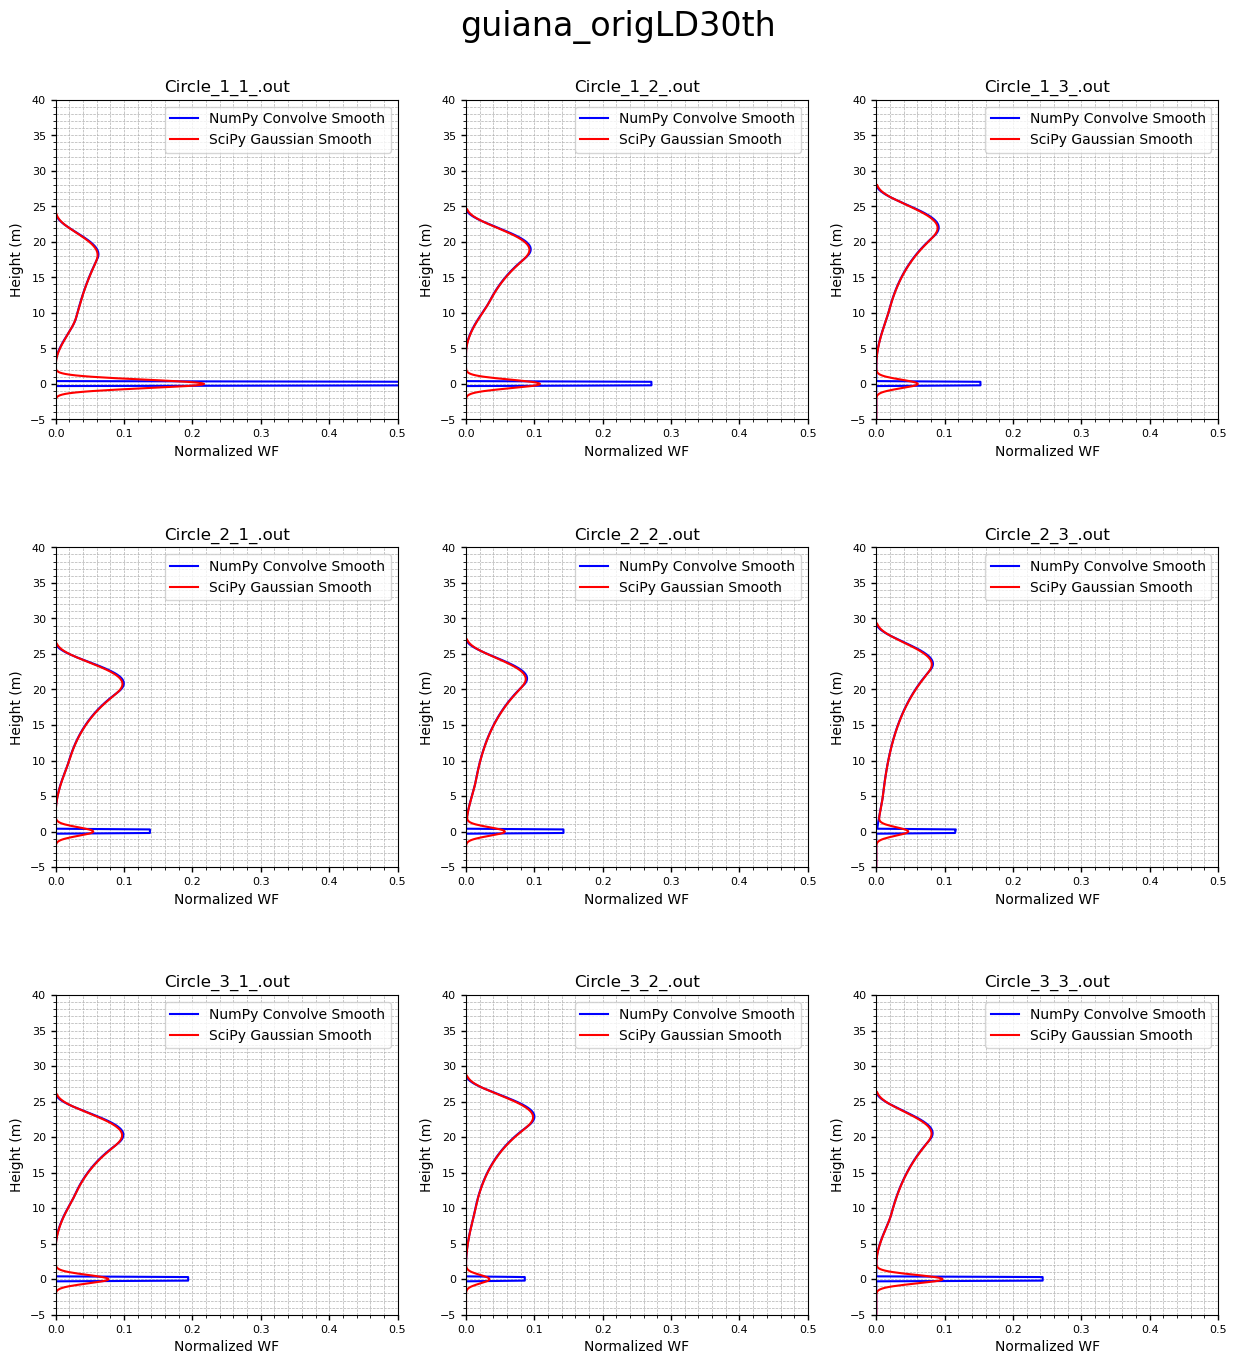

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/guiana_origLD30th_with_branch.pdf


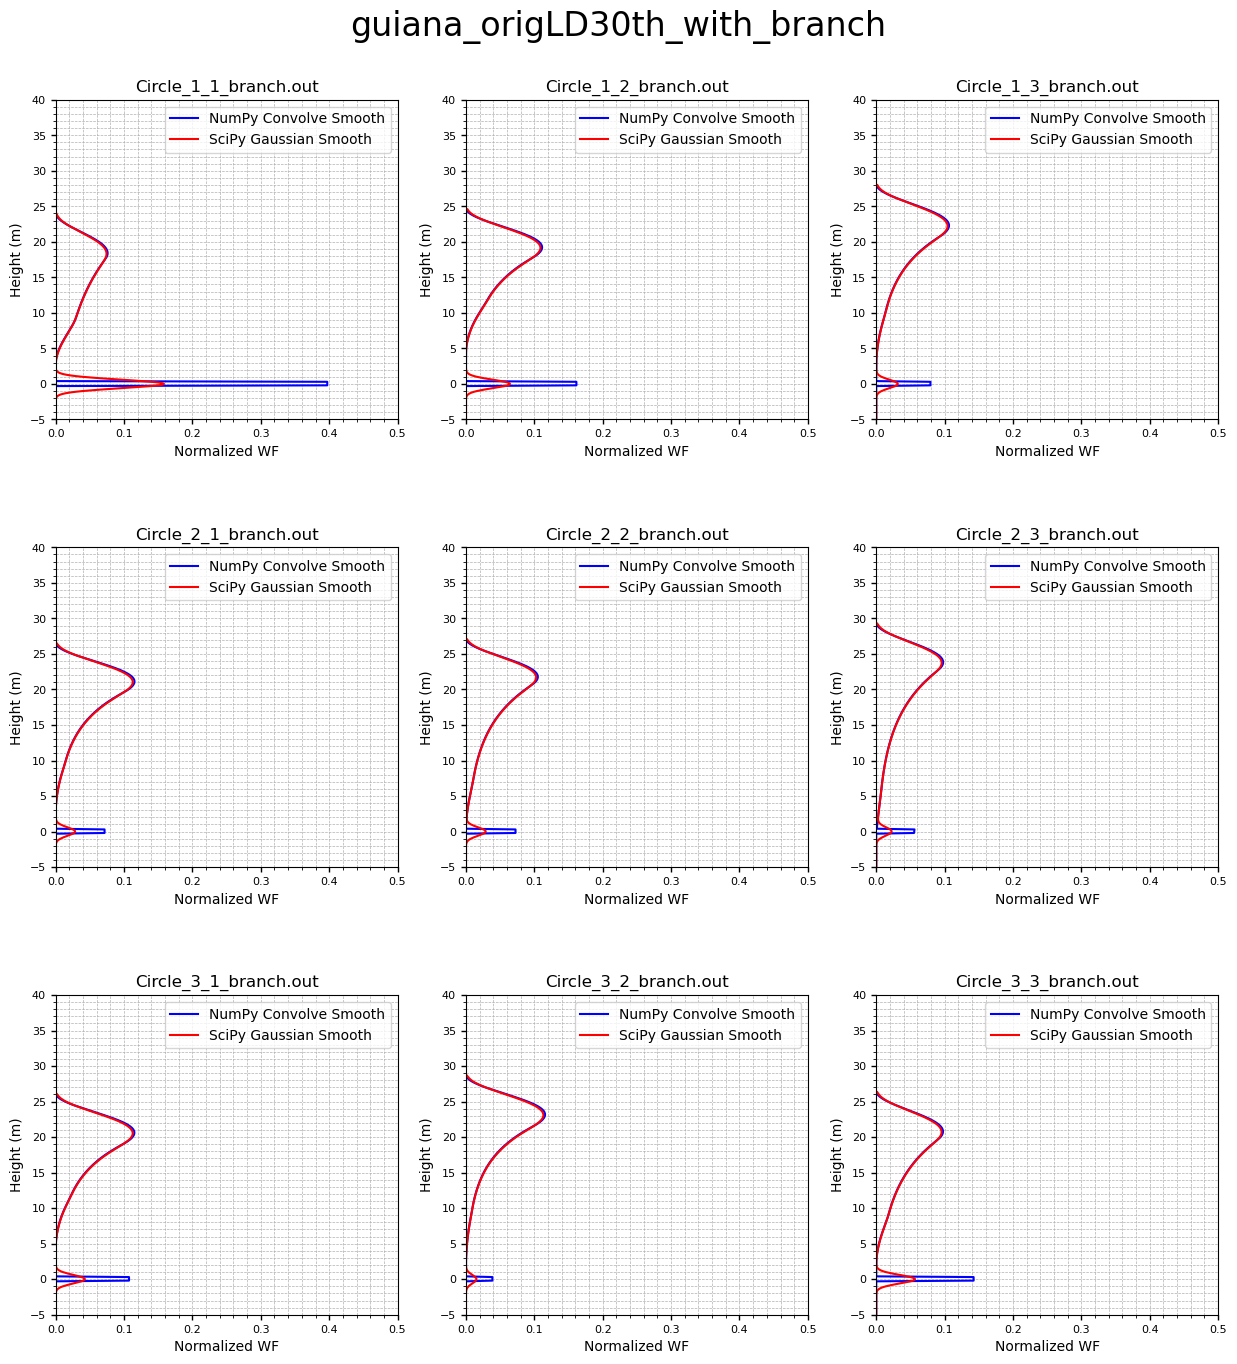

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/redwood_orig.pdf


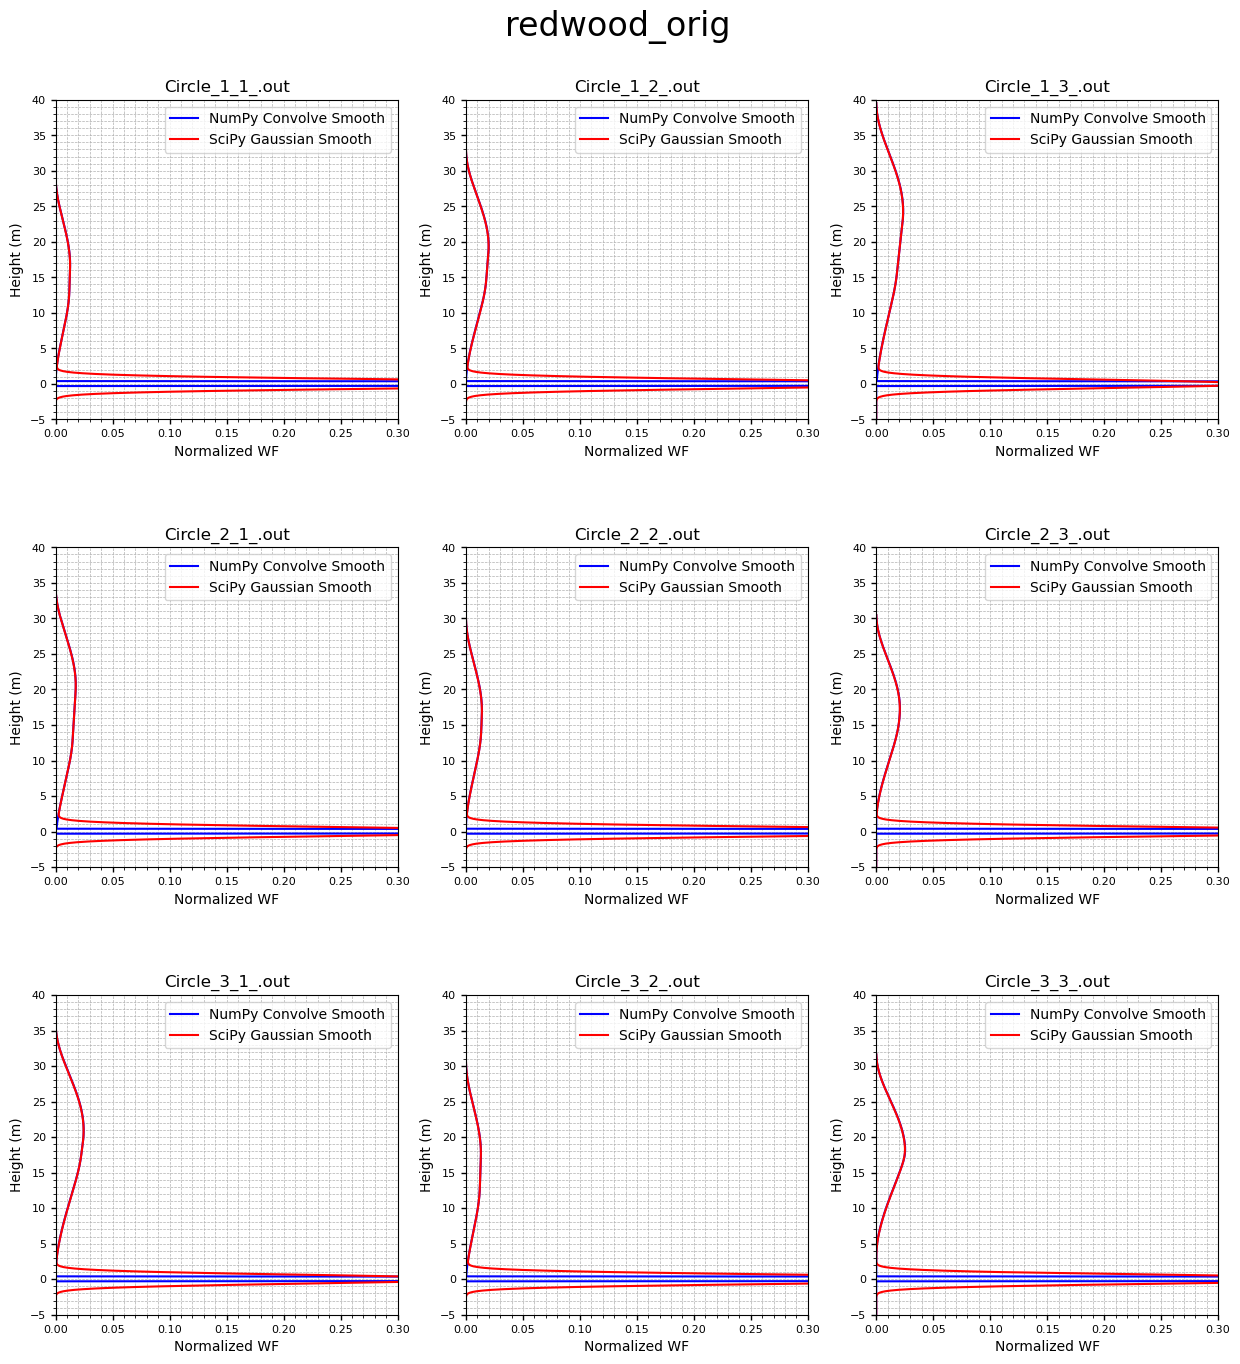

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/redwood_orig_with_branch.pdf


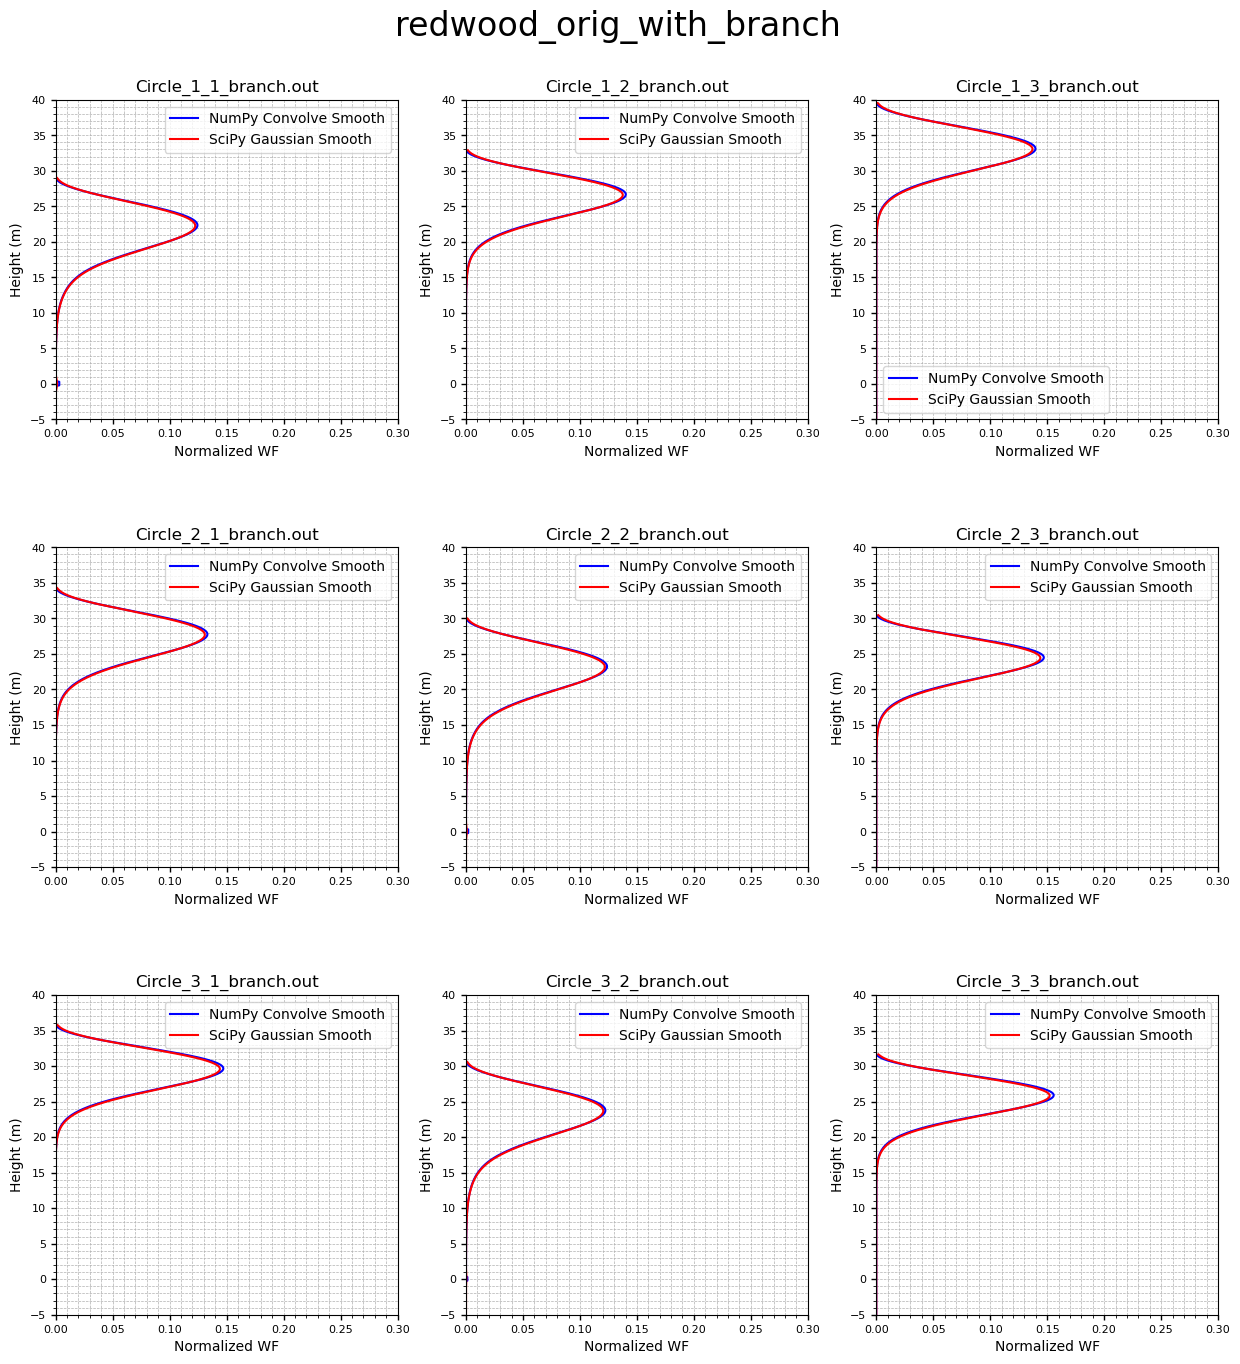

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/redwood_origB10th.pdf


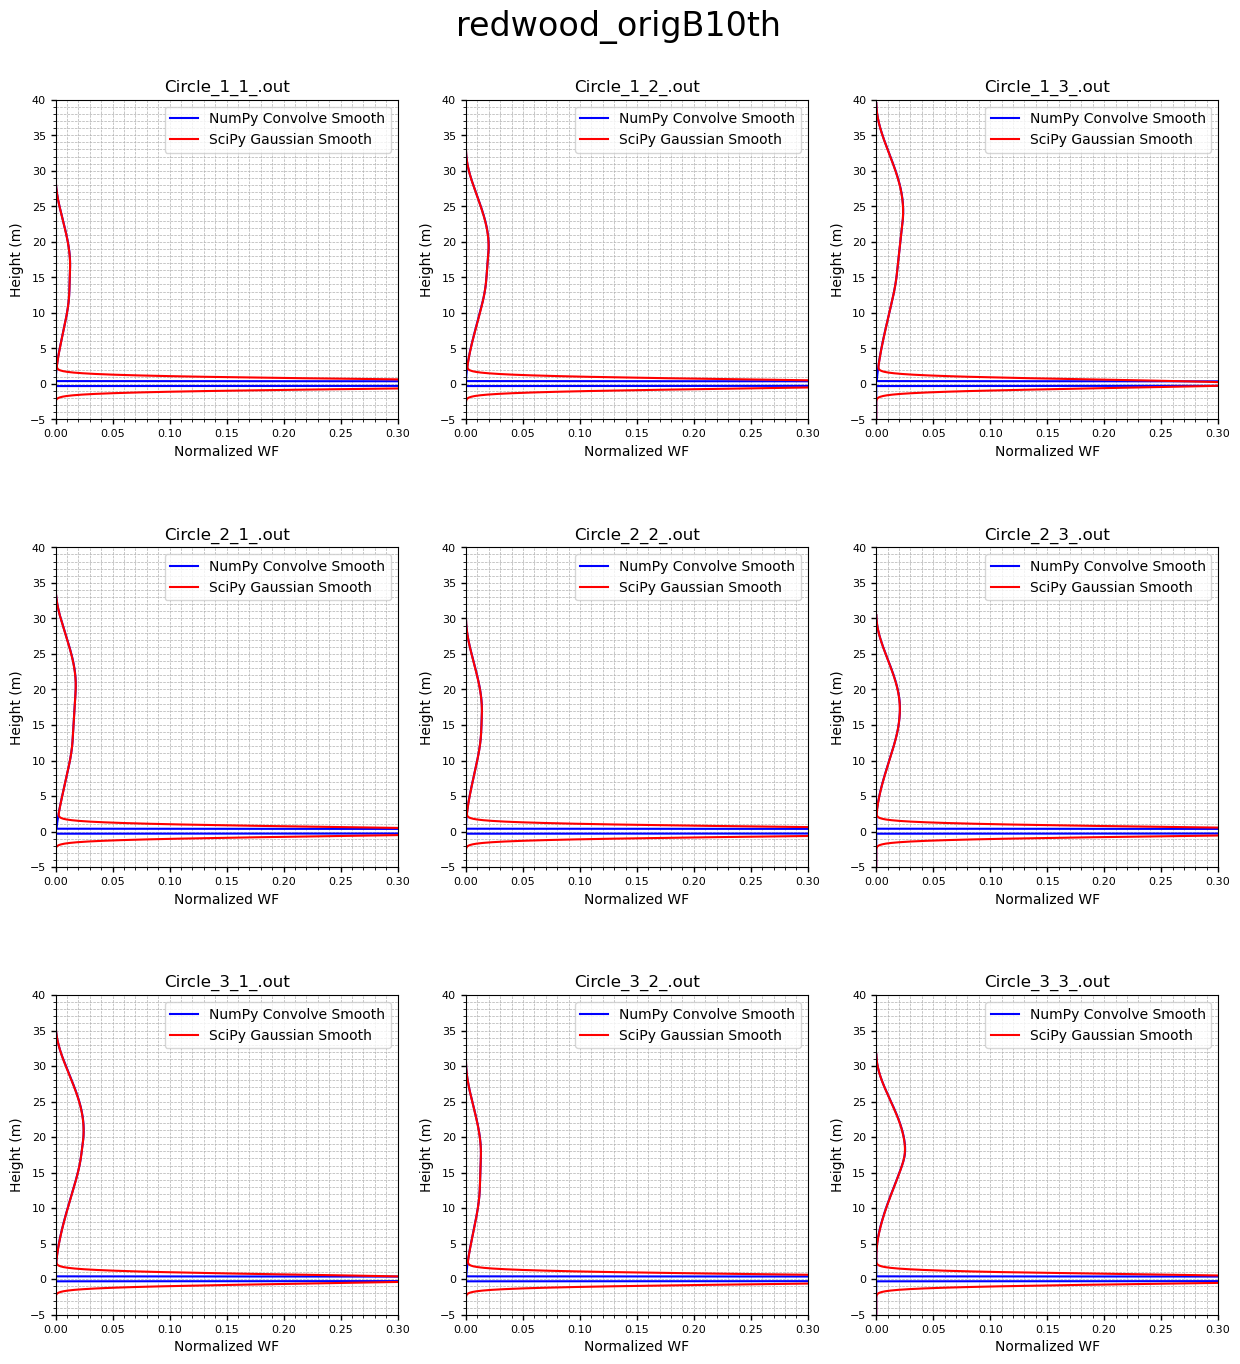

/data/shared/src/STV/LidarSimulation/IDL_plots/wvfm/redwood_origB10th_with_branch.pdf


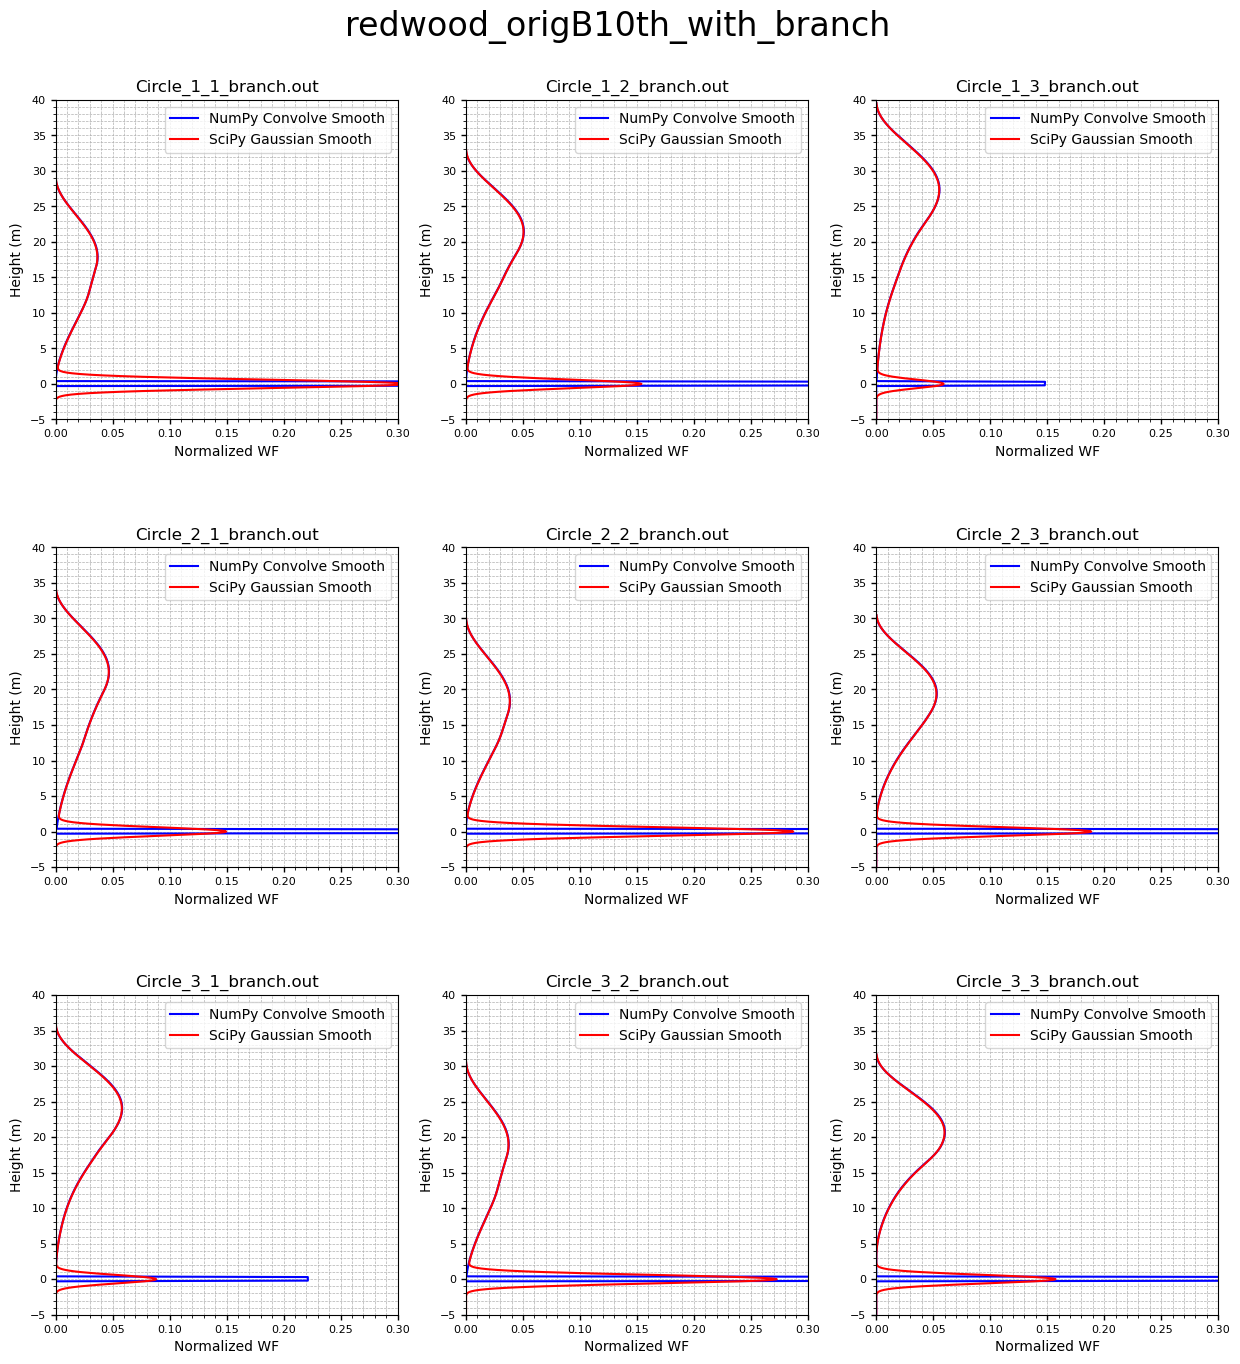

In [21]:
def generate_plots(out_base_dir, subfolder_name):
    script_dir = os.getcwd()
    
    # Ensure the subfolder exists in the current working directory
    save_dir = os.path.join(script_dir, subfolder_name)
    os.makedirs(save_dir, exist_ok=True)
    
    # Get all .out files in the output directory and subdirectories
    out_files = glob.glob(os.path.join(out_base_dir, '**', '*.out'), recursive=True)
    
    # Ensure we have at least 9 .out files to create a 3x3 plot
    if len(out_files) < 9:
        print("Not enough .out files found.")
        return
    
    # Group the .out files into sets of 9
    file_groups = [out_files[i:i + 9] for i in range(0, len(out_files), 9)]
    
    for group_index, file_group in enumerate(file_groups):
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        
        # Determine the plot filename based on the subfolder names of the .out files
        rel_path = os.path.relpath(file_group[0], out_base_dir)  # Get relative path from out_base_dir
        subfolder_names = rel_path.split(os.sep)[:-1]  # Exclude last segments (filename)
        subfolder_filename = '_'.join(subfolder_names)
        
        # Remove any slashes from the subfolder_filename
        subfolder_filename = subfolder_filename.replace('/', '')
        
        # Set suptitle with enough space at the top
        fig.suptitle(subfolder_filename, y=0.98, fontsize=24)
        
        for idx, out_file in enumerate(file_group):
            row = idx // 3
            col = idx % 3
            
            # Reading the gort output file
            with open(out_file, 'r') as f:
                gn_level, dz = map(float, f.readline().split())
                n_ext = int(10.0 / dz)
                n_tot = int(gn_level + n_ext)

                ght = np.zeros(n_tot, dtype=np.float32)
                wvfm = np.zeros(n_tot, dtype=np.float32)
                gwvfm = np.zeros(n_tot, dtype=np.float32)
                ght[:n_ext] = np.arange(n_ext) * dz - 10  # extend height to below ground 10m deep
                wvfm[:n_ext] = 0  # extend wvfm to below ground 10m deep

                for _ in range(3):
                    f.readline()  # skip lines

                for ilevel in range(int(gn_level)):
                    line = f.readline().strip()
                    parts = line.split()
                    parts = [float(part) for part in parts]
                    ght[ilevel + n_ext] = parts[0]
                    wvfm[ilevel + n_ext] = parts[-1]

                width = int(0.6 / dz) + 1
                gwvfm_np_convolve = np.convolve(wvfm, np.ones(width) / width, mode='same')
                gwvfm_gaussian = gaussian_filter(wvfm, sigma = width, mode = 'nearest')

                axes[row, col].plot(gwvfm_np_convolve, ght, label='NumPy Convolve Smooth', color='blue')
                axes[row, col].plot(gwvfm_gaussian, ght, label='SciPy Gaussian Smooth', color='red')
                axes[row, col].set_title(f"{os.path.basename(out_file)}")
                axes[row, col].set_xlabel('Normalized WF')
                axes[row, col].set_ylabel('Height (m)')
                axes[row, col].grid(True, which='both', linestyle='--', linewidth=0.5)
                axes[row, col].minorticks_on()
                axes[row, col].tick_params(labelsize=8, width=1)
                
                # Conditionally set x-axis limits based on subfolder name
                if 'redwood' in subfolder_filename:
                    axes[row, col].set_xlim(0, 0.3)
                elif 'guiana' in subfolder_filename:
                    axes[row, col].set_xlim(0, 0.5)
                    
                axes[row, col].set_ylim(-5, 40)
                # Add legend to the subplot
                axes[row, col].legend()
                
        # Adjust layout and save the plot
        fig.subplots_adjust(top=0.92, hspace=0.4)
        
        plot_filename = os.path.join(save_dir, f"{subfolder_filename}.pdf")
        print(plot_filename)
        
        plt.savefig(plot_filename)
        plt.show()
        plt.close(fig)  # Close the figure to release memory


generate_plots('/data/shared/src/STV/LidarSimulation/OrigGORTOutput/2024_06_26', 'IDL_plots/wvfm')